#  **Author profiling - The writing creates the writer:**
## A model for predicting an author's age and gender

**Authors** (Group 9):

**Emma Quist**

**Thijs Rood**

**David Borensztajn**

Note to the reader: In this document the findings based on "the blogpost dataset" are presented.

To run this notebook on google colaboratory, go to the Project Report file in this folder:
https://colab.research.google.com/drive/1OpYK-wxfyUK69ubJnvr9EJ7t4YXL9eF5?usp=sharing


### **Table of Content**

1.   Introduction
2.   Data Description
3.   Methods Used
4.   Results
      1.   Age prediction
      2.   Gender prediction
      3.   Word
5.   Conclusion
6. Discussion


### **Introduction**
The rise of social media platforms such as Facebook and Twitter over the past two decades, has given enormous amounts of people the power to interact with others on the internet. These web conversations bring many opportunities, as it was never this easy to exchange ideas with people from all over the world. However, there are some issues that emerged from online communication in the digital age.
 
One of the problems is the anonymity of the internet. Setting up an account on one of the major social media platforms is done in just a few steps, no verification is needed. This brings much uncertainty to the identity of a person running an account. People use different names, write under pseudonyms and in some cases pretend to be someone else. This anonymity can be beneficial in terms of user privacy, but it can be dangerous if used for harmful purposes. For example, when being used by online sexual predators.
The Internet is not just for adults: young children grow up on iPads and almost every teenager has a smartphone. But people from these age groups are also vulnerable for sexual predators, operating on the internet. Specifically, 19% of children has been sexually approached online (Mitchell, 2001). Predators are able to falsify their age and come in contact with youth, this shows the importance of online identity monitoring.
Another issue is that non-human users (bots) infiltrate human-to-human communication systems. This forms a problem because the number of bots can be largely scaled and therefore their posts can have great impact on the users of the platform. Scientists found that bots are currently actively influencing popular opinion on major social media platforms (Mesnards et al., 2020). Other research showed that in highly polarised settings, a bot participation of 2-4% of an online networks can be sufficient to tip over the general consensus on the platform (Ross et al., 2019).
These examples clearly show that there is a strong need for user identification. Author profiling could form the solution.

Author profiling aims to correlate writing style with author demographics using natural language processing techniques (Wiegmann et al., 2019). 

Over the last years, texts available on social media platforms have become a primary source of data for computational author profiling (Hsieh et al., 2018). In 2018, researchers showed that age and gender can be predicted using SVM classifiers on TF-IDF features retreived from tweets (Dichiu & Rancea, 2018). Other researchers suggested an approach using three types of features: content based, style based and topic based. They were able to achieve an accuracy of 64.08% on age-group estimation and 56.53% on gender prediction using SVM models and decisions trees (Santosh et al., 2013). However, these papers did not consider the use of neural networks for age and gender prediction.

In this paper, we suggest a neural network-based approach for author profiling on online blogs and chat platforms. The annotated datasets PAN13 and The Blog Authorship Corpus, have been used to model linguistic and semantic features in text to predict authors’ agegroup and gender. The article is composed to answer a three-fold of research questions:

1) To what extend can we predict authors’ age-group in blog and chat texts?

2) To what degree can gender be predicted on the hand of blog and chat texts?

3) How can age- or gender-specific words or features be extracted from the neural network?
 
In the first section, our method and setup will be defined. In the following section we will display the obtained results. Lastly, we will wrap up our project and discuss the outcome.
 


### **Importing dependencies**

In [ ]:
# Loading files from drive
from google.colab import drive
drive.mount('/content/drive')

# Uploading files directly
# from google.colab import files
# uploaded = files.upload()
# dataset_blog = pd.read_excel(uploaded)
# df = pd.DataFrame(dataset_blog)



%load_ext tensorboard
!pip install torchtext==0.4.

import pandas as pd
import re
import os
import time

import torch
import torchtext
from torchtext.datasets import text_classification
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import nltk
from torch.utils.tensorboard import SummaryWriter
import tensorflow as tf
import tensorboard as tb
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

from collections import defaultdict, OrderedDict, Counter
import operator
from IPython.display import Image
import plotly.graph_objs as go

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### **Data Description**

As we needed a dataset which both included an authors texts and its age or gender we stumbled upon the following datasets:

**The PAN dataset series**

The [PAN dataset series](https://pan.webis.de/data.html) consists of more than 10 datasets with text documents usable for various tasks such as: Author Identification, Plagiarism Detection, Quality Flaw Prediction and Author Profiling. As the research question concerns the latter task it is apparent one of these datasets was picked. After permission to the PAN 13 dataset was given it was decided it would be used in our research. 

The PAN 13 (from 2013) dataset contains anonymous texts collected from social media platforms. The files are ordered in a XML structure and contain the language in which the texts were written, the amount of texts per user, the users age and its gender. In this research we decided to only process English texts to keep it accessible and still keep the most files. The pan age ranges are: 10s: 13-17 yrs (17.200 conversations), 20s: 23-27 yrs (85.800 conversations) and 30s: 33-47yrs (133.600 conversations)


**The Blog Authorship Corpus**

The [Blog Autorship Corpus](http://www.cs.biu.ac.il/~schlerj/schler_springsymp06.pdf) is a dataset consisting of 19320 collected posts from bloggers on blogger.com in August 2004. The corpus is free to use for non-commercial purposes. In the corpus are 681.288 posts in total, together forming over 140 million words. This makes up for an average of 35 posts and 7250 words per person.

Each file is filled with a different blogpost, the authors (self-provided) age, gender, and astrological sign. The age of the authors is normally distributed around the age 16-24 with a skew and thin distribution towards the higher ages. The amount of male and females is equally represented.


Together with our TA it was decided that using these two datasets would satisfy the requirements and should suffice to complete our research.

**Imbalanced Data**

As we have stated before, both datasets are not uniformly distributed on age. This means that the data should be balanced before training the model. In this research we used a resampling approach to solve this problem. Because the size of both datasets was sufficient, under-sampling could be used. Under-sampling balances the dataset by reducing the size of the abundant class (‘7 Techniques to Handle Imbalanced Data’, 2021). This has been done by keeping all samples of the smallest age-group and randomly selecting an equal number of samples in the larger age-groups. The outcome is a balanced dataset, that is suitable for training a neural network with less bias.



### **Methods and approach**

**Preprocessing steps**

Before applying an analysis on the data it is important to load it in carefully and at think about other pre-processing steps. In this research the non-alphabetic characters were removed, text was lowered and tokenised. To predict an authors age and gender the style of the text had to be retained as much as possible. Therefore it was decided not to remove stopwords and to not lemmatize the words. It might be argued that different groups of people tend to choose different words in their sentences. In this research unigrams were used for simplicity, bigrams might improve later performance.



In [ ]:
path = '/content/drive/MyDrive/Language, speech and dialogue processing/'

dataset_blog = pd.read_excel(path+'blogtext_full.xlsx')
df = pd.DataFrame(dataset_blog)
df = df.drop(['id', 'topic', 'sign', 'date'], axis=1)
# df = df.sample(150000)
#df_PAN = pd.read_csv(path+'sub_PAN.csv')
#df_PAN = df_PAN.drop(['Unnamed: 0'], axis=1)
#df_PAN.columns = ['age','gender', ]


def tokenize(text):
    tokens = [token for token in text.split(" ") if token != ""]
    return tokens

def lowered(s):
    return s.lower()

# removing non alphabetic strings function
def remove_nonalph(s):
      s = re.sub(r'[^a-zA-Z0-9\s]', ' ', s)
      return s

# applying preprocessing steps
df['text'] = df['text'].apply(lowered).apply(remove_nonalph).apply(tokenize)
#df_PAN["text"] = df_PAN["text"].apply(lowered).apply(remove_nonalph).apply(tokenize)

In [ ]:
df.head()

,gender,age,text
34868,male,25,"[here, s, the, latest, from, my, man, bill, si..."
315773,female,17,"[hahahaha, ok, rob, you, realize, you, have, t..."
129621,male,23,"[spent, last, night, over, at, james, s, house..."
631977,male,33,"[urllink, http, www, moveon, org, if, american..."
211881,male,14,"[hello, there, the, angel, of, my, nightmare, ..."


**Word and classes mapping**

After these steps the words had to be represented into numbers in order to make use of them in a neural network. The word mapping chosen was integer encoding. Each word in the vocabulary gained a number from 0 to N (amount of unique words) in order of frequency. After this the text documents could be translated into tensors, which are large arrays designed for neural networks. The same mapping was applied on the classes (either age groups or gender groups).

In [ ]:
class_choice = 'age'
classdict = defaultdict(int)

for row in df[class_choice]:
  classdict[row] += 1

classdict = dict(sorted(classdict.items(), key=operator.itemgetter(1), reverse=True))

classlist = list(classdict.keys())
classmap = dict([(y,x) for x,y in enumerate(classlist)])
print('Original age distribution of dataset:')

x = tuple(classdict.keys())
y = list(classdict.values())
fig = go.Figure([go.Bar(x=x, y=y)])
fig.show()

Original age distribution of dataset:


**Balancing and creating age groups**

In [ ]:
ages = df["age"].unique().tolist()
print(ages)

ages.sort()
age_dict = {}
for age in ages:
  age_dict[age] = df.loc[df['age'] == age]

for key, value in age_dict.items():
  age_dict[key] = value

# Same range as in pan13 dataset, with an extra 40's group

dataframes_10s = []
dataframes_20s = []
dataframes_30s = []
dataframes_40s = []

for key, value in age_dict.items():
  if 13 <= int(key) <= 17:
    dataframes_10s.append(value)
  elif 23 <= int(key) <= 27:
    dataframes_20s.append(value)
  elif 33 <= int(key) <= 37:
    dataframes_30s.append(value)
  elif 43 <= int(key) <= 47:
    dataframes_40s.append(value)

df_10s = pd.concat(dataframes_10s)
df_20s = pd.concat(dataframes_20s)
df_30s = pd.concat(dataframes_30s)
df_40s = pd.concat(dataframes_40s)

all_dataframes = [df_10s, df_20s, df_30s, df_40s]

min_len = len(all_dataframes[0])

for df in all_dataframes:
  if len(df) < min_len:
    min_len = len(df)

df_10s["age"] = 0
df_20s["age"] = 1
df_30s["age"] = 2
df_40s['age'] = 3

all_dataframes = [df_10s.sample(min_len), df_20s.sample(min_len), df_30s.sample(min_len), df_40s.sample(min_len)]

df = pd.concat(all_dataframes)
df.index = range(len(df))

[25, 17, 23, 33, 14, 35, 41, 15, 16, 34, 13, 26, 38, 27, 45, 24, 46, 36, 48, 37, 39, 44, 47, 40, 43, 42]


**Visualizing new balanced groups**

In [ ]:
classdict = defaultdict(int)

for row in df[class_choice]:
  classdict[row] += 1

classdict = dict(sorted(classdict.items(), key=operator.itemgetter(1), reverse=True))

classlist = list(classdict.keys())
classmap = dict([(y,x) for x,y in enumerate(classlist)])
print('Balanced dataset with age groups:')

x = ["10s", "20s", "30s", "40s"]
y = list(classdict.values())
fig = go.Figure([go.Bar(x=x, y=y)])
fig.show()

Balanced dataset with age groups:


**Creating a vocabulary**

In [ ]:
# creating vocabulary of words
vocabdict = defaultdict(int)   
for row in df['text']:
  for n_gram in row:
    n_gram = n_gram.lower()
    vocabdict[n_gram] += 1

vocabdict = dict(sorted(vocabdict.items(), key=operator.itemgetter(1), reverse=True))

# mapping words to integer
l = list(vocabdict.keys())
wordmap = dict([(y,x) for x,y in enumerate(l)])
print(wordmap)

{'the': 0, 'i': 1, 'to': 2, 'and': 3, 'a': 4, 'of': 5, 'it': 6, 'in': 7, 'that': 8, 'is': 9, 'you': 10, 'my': 11, 's': 12, 'for': 13, 'was': 14, 'on': 15, 't': 16, 'with': 17, 'this': 18, 'but': 19, 'have': 20, 'me': 21, 'we': 22, 'be': 23, 'he': 24, 'so': 25, 'at': 26, 'not': 27, 'as': 28, 'all': 29, 'are': 30, 'they': 31, 'her': 32, 'she': 33, 'nbsp': 34, 'just': 35, 'like': 36, 'out': 37, 'what': 38, 'up': 39, 'about': 40, 'm': 41, 'from': 42, 'or': 43, 'one': 44, 'can': 45, 'if': 46, 'there': 47, 'his': 48, 'do': 49, 'had': 50, 'will': 51, 'when': 52, 'urllink': 53, 'by': 54, 'get': 55, 'time': 56, 'an': 57, 'some': 58, 'who': 59, 'now': 60, 'know': 61, 'would': 62, 'no': 63, 'more': 64, 'your': 65, 'then': 66, 'has': 67, 'don': 68, 'him': 69, 'been': 70, 'were': 71, 'people': 72, 'them': 73, 'go': 74, 'really': 75, 'think': 76, 'how': 77, 'am': 78, 'good': 79, 'well': 80, 'our': 81, 'their': 82, 'back': 83, 'going': 84, 'day': 85, 'because': 86, 'see': 87, 'got': 88, 'which': 89, 

**Integer encoding and creating tensors**

In [ ]:
df_copy = df.copy()

for i, text in enumerate(df['text']):
  newtext = []
  for word in text:
    word = word.lower()
    newtext.append(int(wordmap[word]))
  df['text'][i] = torch.tensor(newtext).to(torch.int64)

train_dataset = []

for index, row in df.iterrows():
  clasn = classmap[row['age']]
  train_dataset.append(tuple((clasn, row['text'])))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**Embdedded Neural Network**

The neural network model, coded below, mainly consists of an embedding layer with fully connected units to each of the classes. An embedding layer works by taking the words of a tensor and tries to build a lower dimensional embedding. Similar words gain a similar vectors which makes classification easier. The weights from the layers are uniformly distributed from $-\frac{1}{2}$ to $+\frac{1}{2}$ and the biases were set to 0.

As input for the embedding layer the vocabulary size and embedding dimension should be given. The words in the vocabulary size will first form a vector filled with 0's only representing the given word with a 1. The embedding dimension gives the space size to which all words should be mapped. The number of classes should be given as well as the fully connected layer should know to what amount of dimensions to map.

The Neural Network was trained using an embeddings of 32 dimensions. The texts were split and put in batches of 16. The stochastic gradient descent optimizer with a starting learning rate of 0.4 was used, together with a scheduler with a gamma of 0.9 which should decay this learning rate. As a loss function, the cross entropy loss was used, since this is a recommended loss function for binary predictions.

The usage of a embedded network was chosen since people of different groups tend to use similar words. The vectors in the embedding layer for these groups should therefore be more alike. Younger groups, as an example, write more about things related to their age than older groups. The usage of these embedding vectors could therefore be used to classify texts. The last fully connected hidden layer maps these vectors to a corresponding age.

In [ ]:
# set GPU as device for better performance
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TextSentiment(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

vocab = len(vocabdict)
embed_dim = 32
n_classes = len(classdict)
BATCH_SIZE = 16
model = TextSentiment(vocab, embed_dim, n_classes).to(device)
writer = SummaryWriter('runs/lsd')

**Recurrent Neural Network**

As an alternative to the neural network above we also ran the experiment on a recurrent neural network (RNN). The idea behind RNN's is that they make use of sequential information. This can be useful for texts because language has a clear sequential character. The model we used is called a Long Short-Term Memory Network (LTSM). As the name says, it remembers previous word inputs from short and longer periods back. The meaning of a word meaning depends on preceding words, therefore LTSM's can be used to extract this sequential information for a better classification task. The code and setup of these RNN classifiers can be found in the other notebooks.



### **Results**


The final part of the implementation of the embedded neural network is demonstrated below, here we generate the batch, define the functions for the training and test data and run the network with 30 epochs (on the sub-dataset of 999 blogposts). In order to evaluate our neural network, we started by calculating the loss and accuracy. The loss measures the cross-entropy-loss, this combines the log softmax function (LogSoftmax) and negative log likelihood loss (NLLLoss) in one single class to calculate the loss per epoch. This criterion has been chosen in our case since it is especially useful when training a classification problem with C classes.  The accuracy measures the percentage of blogposts that was correctly labeled and, for both the training and validation data. For example, if the model predicts the correct age group 60 times in a test set containing 100 authors’ text, this will result in an accuracy of 60%.


In [ ]:
def generate_batch(batch):
    label = torch.tensor([entry[0] for entry in batch])
    text = [entry[1] for entry in batch]
    offsets = [0] + [len(entry) for entry in text]
    # torch.Tensor.cumsum returns the cumulative sum
    # of elements in the dimension dim.
    # torch.Tensor([1.0, 2.0, 3.0]).cumsum(dim=0)

    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text = torch.cat(text)
    return text, offsets, label

def train_func(sub_train_):

    # Train the model
    train_loss = 0
    train_acc = 0
    data = DataLoader(sub_train_, batch_size=BATCH_SIZE, shuffle=True,
                      collate_fn=generate_batch)
    for i, (text, offsets, cls) in enumerate(data):
        optimizer.zero_grad()
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        output = model(text, offsets)
        loss = criterion(output, cls)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_acc += (output.argmax(1) == cls).sum().item()

    # Adjust the learning rate
    scheduler.step()

    return train_loss / len(sub_train_), train_acc / len(sub_train_)

def test(data_):
    loss = 0
    acc = 0
    data = DataLoader(data_, batch_size=BATCH_SIZE, collate_fn=generate_batch)
    for text, offsets, cls in data:
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        with torch.no_grad():
            output = model(text, offsets)
            loss = criterion(output, cls)
            loss += loss.item()
            acc += (output.argmax(1) == cls).sum().item()

    return loss / len(data_), acc / len(data_)

N_EPOCHS = 30
min_valid_loss = float('inf')

criterion = torch.nn.CrossEntropyLoss().to(device)
# Adam of SGD
optimizer = torch.optim.SGD(model.parameters(), lr=4.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

train_len = int(len(train_dataset) * 0.95)
sub_train_, sub_valid_ = \
    random_split(train_dataset, [train_len, len(train_dataset) - train_len])

start_time = time.time()
for epoch in range(N_EPOCHS):

    train_loss, train_acc = train_func(sub_train_)
    valid_loss, valid_acc = test(sub_valid_)

    print('Epoch: %d' %(epoch + 1))
    print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
    writer.add_scalar('loss', train_loss, epoch)
    print(f'\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.1f}%(valid)')
    writer.add_scalar('test acc', valid_acc, epoch)

total_time = int(time.time() - start_time)
print('Total time elapsed: %d seconds.' %(total_time))

Epoch: 1
	Loss: 0.0739(train)	|	Acc: 54.2%(train)
	Loss: 0.0014(valid)	|	Acc: 51.8%(valid)
Epoch: 2
	Loss: 0.0614(train)	|	Acc: 59.8%(train)
	Loss: 0.0010(valid)	|	Acc: 59.9%(valid)
Epoch: 3
	Loss: 0.0570(train)	|	Acc: 64.0%(train)
	Loss: 0.0019(valid)	|	Acc: 52.0%(valid)
Epoch: 4
	Loss: 0.0530(train)	|	Acc: 66.8%(train)
	Loss: 0.0012(valid)	|	Acc: 59.8%(valid)
Epoch: 5
	Loss: 0.0502(train)	|	Acc: 69.3%(train)
	Loss: 0.0015(valid)	|	Acc: 60.9%(valid)
Epoch: 6
	Loss: 0.0480(train)	|	Acc: 71.9%(train)
	Loss: 0.0012(valid)	|	Acc: 53.4%(valid)
Epoch: 7
	Loss: 0.0456(train)	|	Acc: 73.4%(train)
	Loss: 0.0023(valid)	|	Acc: 60.5%(valid)
Epoch: 8
	Loss: 0.0428(train)	|	Acc: 74.9%(train)
	Loss: 0.0015(valid)	|	Acc: 58.8%(valid)
Epoch: 9
	Loss: 0.0415(train)	|	Acc: 76.7%(train)
	Loss: 0.0007(valid)	|	Acc: 62.1%(valid)
Epoch: 10
	Loss: 0.0386(train)	|	Acc: 78.7%(train)
	Loss: 0.0012(valid)	|	Acc: 63.0%(valid)
Epoch: 11
	Loss: 0.0361(train)	|	Acc: 80.2%(train)
	Loss: 0.0007(valid)	|	Acc: 63.5%(vali

For the neural network model on the full dataset, we have acquired an accuracy of respectively 63.7% after training for 50 epochs (see dataframe below). The loss and accuracies of the different models and datasets are also shown in dataframe below. 
For the Recurrent Neural Network, we have chosen to calculate the loss of the training and test set and the accuracy of the validation set, just like the other model. Besides this, the root mean square error (RSME) of the validation set has been calculated as well, this is an extra way to measure the error of a model. 

In [ ]:
df_results = pd.read_csv(path+'results_acc.csv', sep=';', index_col=0)
df_results.head()

,NN Blog autorship,NN PAN13,RNN Blog autorship,RNN PAN 13
Dataset,,,,
Loss train,0.0153,0.0443,0.2717,0.0724
Loss valid,0.0001,0.0004,1.4837,2.8548
Acc. train,91.7%,68.6%,NaN,NaN
Acc. valid,70.7%,48.6%,56.8%,50.1%
RMSE valid,NaN,NaN,82.2,103.1


### Confusion matrices
A potential problem of accuracy measurement is that it might yield misleading results when the dataset is unbalanced, which was the case before we balanced our datasets. In case of the use of an unbalanced dataset or to assess whether the model assigns the labels evenly in general, it is important to calculate other metrics as well. For our evaluation we made use of a confusion matrix, a table that describes de performance of a classification model. It gives a better insight into the errors. The confusion matrices for both datasets and both models are visualized in the four plots below.


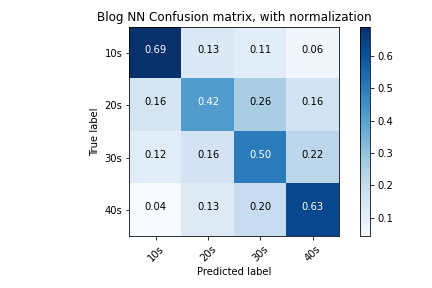

In [ ]:
Image(path+'Blog_nn_confusion_matrix.png')

Predictions



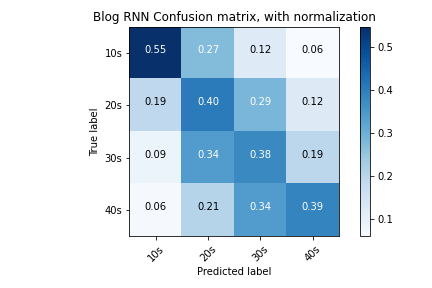

In [ ]:
Image(path+'Blog_rnn_confusion_matrix.png')

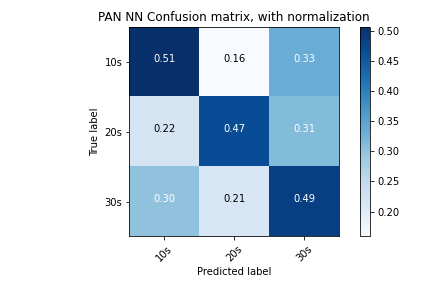

In [ ]:
Image(path+'PAN_nn_confusion_matrix.png')

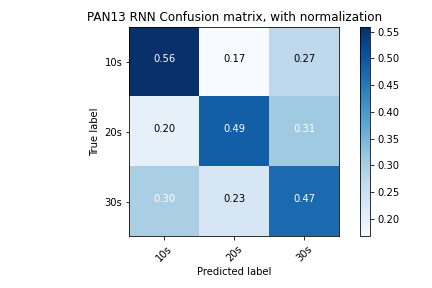

In [ ]:
Image(path+'PAN_rnn_confusion_matrix.png')

In [ ]:
def predict(text, model, wordmap):
    sentence = []
    for word in text:
      word = word.lower()
      sentence.append(int(wordmap[word]))
    text = torch.tensor(sentence).to(torch.int64)

    with torch.no_grad():
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item() + 1



test_text = df_copy['text'][1]

model = model.to("cpu")

inv_map = {v: k for v, k in [(0,"10's"), (1,"20's"), (2,"30's"), (3,"40's")]}

print(f"I predict the author of this article is in his {inv_map[predict(test_text, model, wordmap)]}")

I predict the author of this article is in his 20's


### **Conclusions**


Above results give us some insights on the predictive performance of the networks. First of all, the matrices show that most true positives are in the 10's age group. Besides that, no clear patterns are visible in the confusion matrices. We can conclude that the (normal) neural network gives the best performance for age classification. The sequential information that the RNN uses in the prediction does not result in higher accuracy or better performance.

This research has clearly shown that age and gender can be predicted with a neural network approach. However, there is still much room for future research. First of all, another method of word embeddings would be one-hot encodings. This would give unique word dimensions, and it would assume fully independent words. Another way of embedding words would be to use a pre-trained embedding model. The advantage of pre-trained word vectors (e.g. word2vec) would be that similar words get similar vectors. The exact effects of these embeddings are not clear but these options could possibly lead to better predictive perfomance. Another interesting research would be to cross-validate the models on both datasets. This gives more insight on the "real" predictive power of the models.

### **References**
7 Techniques to Handle Imbalanced Data. (2021). KDnuggets. Geraadpleegd 11 maart 2021, van https://www.kdnuggets.com/7-techniques-to-handle-imbalanced-data.html/

Dichiu, D., & Rancea, I. (z.d.). Using Machine Learning Algorithms for Author Profiling In Social Media. 6.

Hsieh, F., Dias, R., & Paraboni, I. (2018, May). Author Profiling from Facebook Corpora. Proceedings of the Eleventh International Conference on Language Resources and Evaluation (LREC 2018). LREC 2018, Miyazaki, Japan. https://www.aclweb.org/anthology/L18-1407

Mesnards, N. G. des, Hunter, D. S., Hjouji, Z. el, & Zaman, T. (2020). Detecting Bots and Assessing Their Impact in Social Networks. ArXiv:1810.12398 [Physics, Stat]. http://arxiv.org/abs/1810.12398

Mitchell, K. J. (2001). Risk Factors for and Impact of Online Sexual Solicitation of Youth. JAMA, 285(23), 3011. https://doi.org/10.1001/jama.285.23.3011

Ross, B., Pilz, L., Cabrera, B., Brachten, F., Neubaum, G., & Stieglitz, S. (2019). Are social bots a real threat? An agent-based model of the spiral of silence to analyse the impact of manipulative actors in social networks. European Journal of Information Systems, 28(4), 394–412. https://doi.org/10.1080/0960085X.2018.1560920

Santosh, K., Bansal, R., Shekhar, M., & Varma, V. (2013, januari 1). Author Profiling: Predicting Age and Gender from Blogs Notebook for PAN at CLEF 2013.

Wiegmann, M., Stein, B., & Potthast, M. (2019). Overview of the Celebrity Proﬁling Task at PAN 2019. 19.

